# Gyration plane Tutorial

Welcome to the Gyration plane tutorial! In this tutorial you will learn:
* What is **gyration number** and how it can be computed for any neural activity dataset;
* How **gyration number** can be represented on the **gyration plane**;
* How to compare different real neural datasets on the **gyration plane**.

Let's start with importing our newly developed functions providing interface for rotational analysis of a neural dataset.

In [1]:
from utils.datasets import (GraspingSuresh, 
                            ReachingGallego, 
                            ReachingChurchland, 
                            ReachingKalidindi, 
                            BehaviouralMante, 
                            SyntheticTravelingWave)
from utils.vis import plot_dataset_gyration_plane, peth_normalize
from utils.utils import generate_response
from utils.color_palettes import blue_yellow_cmap
from jPCA.util import plot_projections, preprocess
import jPCA
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

# Gyration number intuition

Do you remember the concept of covariance matrix? For __centered__ dataset $X \in \mathbf{R}^{t\times n}$ the covariance matrix $C$ reads as $C = X^TX$. In the context of neural recordings this matrix catches the information about the covariance of neurons with each other. We omit great properties of eigendecomposition you can find on the [wiki](https://en.wikipedia.org/wiki/Covariance_matrix). Now we introduce another interesting concept - differential covariance matrix. We define this matrix as $D = \dot{X}^TX$ where $\dot{X} \in \mathbf{R}^{t\times n}$ is the "somehow" computed matrix of first derivative of $X$ (for example by simple `numpy.diff` function). The brilliant property of this matrix is that it is [skew-symmetric](https://en.wikipedia.org/wiki/Skew-symmetric_matrix) when the datasets has intrinsic circular structure (or rotational dynamics). If not, this matrix can be even just symmetric (case of independent decaying of neurons). Another cool property of this matrix is that its structure can be briefly characterized by several eigenvalues (e.g. 2 largest ones). 

It's time to try!

Generating datasets!
Each condition for all neurons


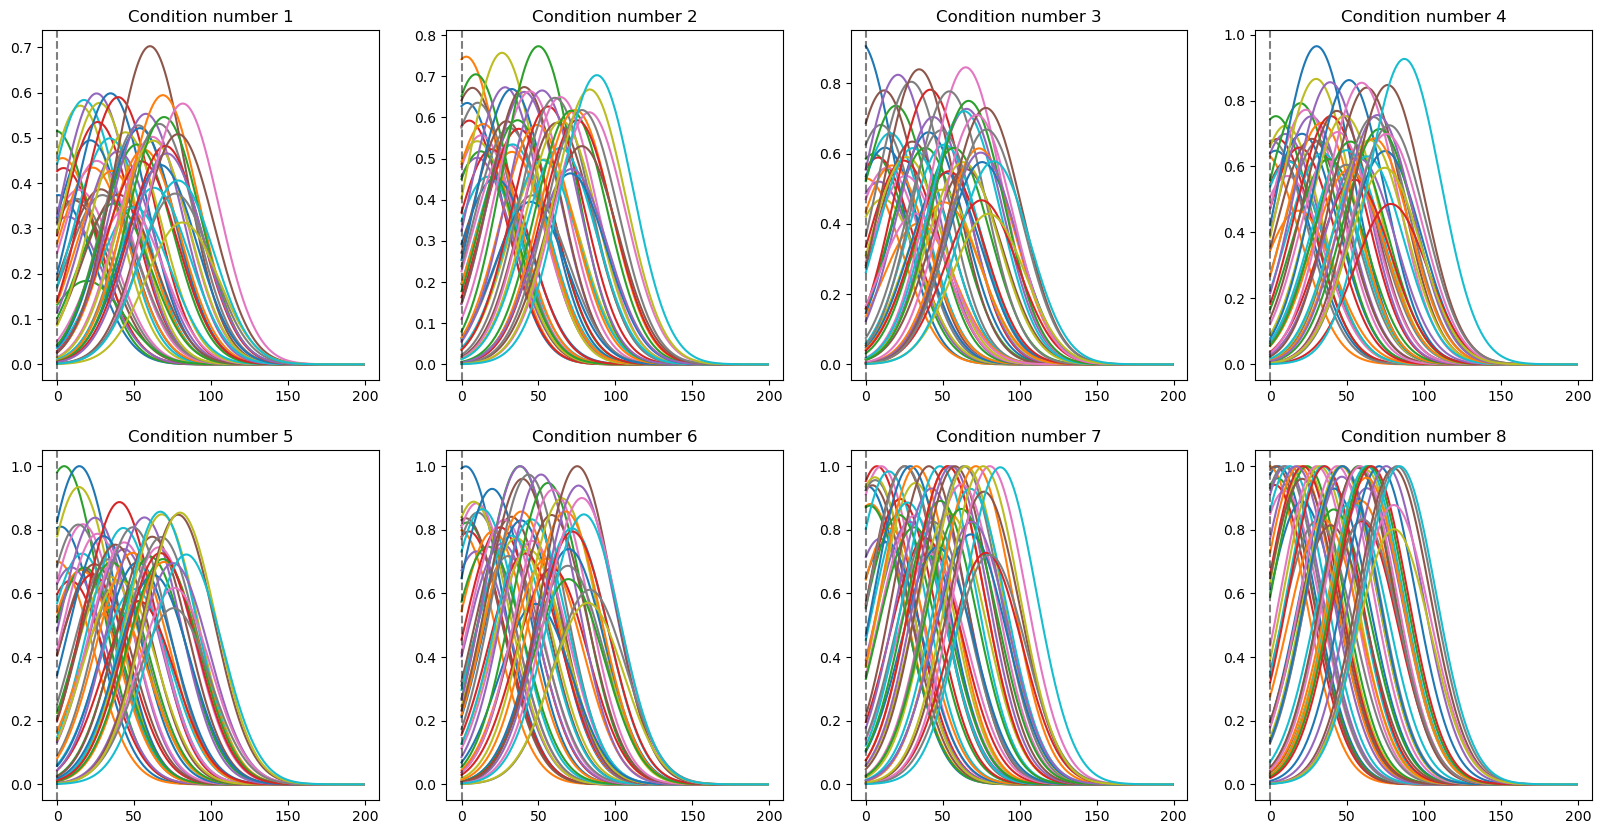

In [2]:
# Let's first create a simple synthetic dataset of 4 conditions and enjoy its rotational dynamics.

# let's initialize a class for dataset
syn = SyntheticTravelingWave('datasets')

# define parameters for synthetic dataset, 
# you shouldn't bother about this parameters now, just trust us :)
p = {'amp_noise':0.1, 
     'phase_noise':10, 
     'sigma_noise':0, 
     'sigma':100, 
     'ncond':8,     # <--- number of conditions
     'a':0, 
     'b':5.1, 
     't_max':600, 
     'N':50,        # <--- number of neurons
     'steps':200
     }
syn.preprocess_data(**p)

#plot all neurons with each of the condition to understand neural dynamics within conditions
syn.plot_conditions(subtract_mean=False)

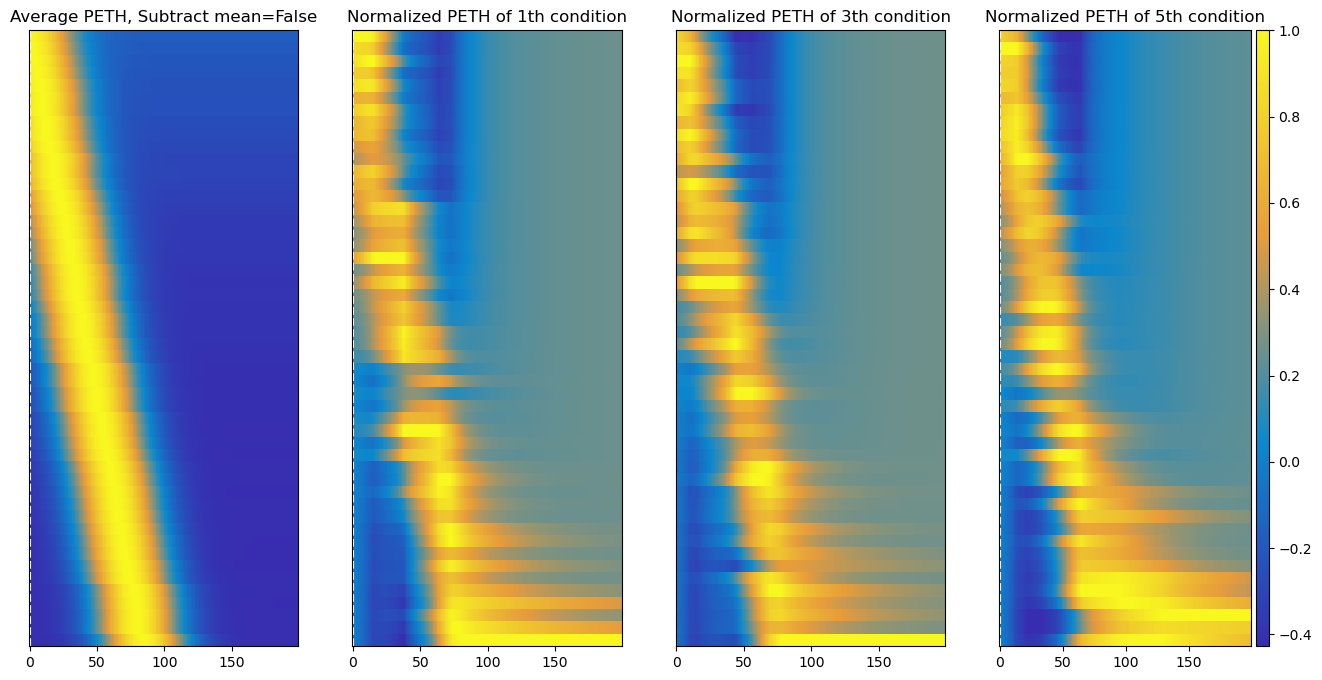

In [3]:
#let's plot PETH (Peri-Event Time Histogram), aka "the top view" on running wave
syn.plot_peth(subtract_mean=False, cond_list=[1, 3, 5])

jPCA


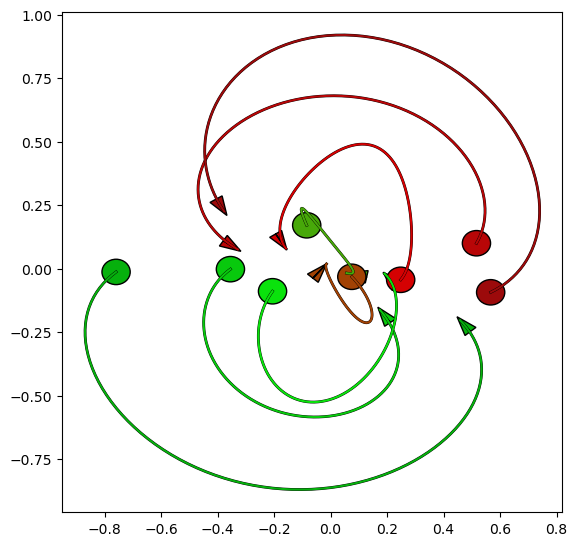

In [4]:
#finally let's plot jPCA
syn.plot_jpca(tstart=0, tend=90)

Do you see the clear rotational dynamics in the synthetic dataset? If yes, can we quantify this "rotationess" somehow? The differential covariance matrix discussed previously is key to this quantification. Let's build this matrix for one condition...

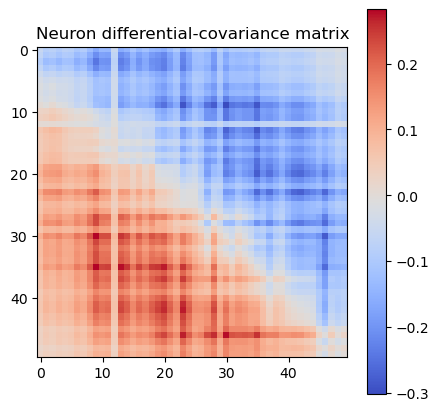

In [23]:
c = syn.data[0]

X = np.concatenate([x[:-1] for x in [c]])
X_dot = np.concatenate([np.diff(x, axis=0) for x in [c]])
dcov_N = X_dot.T @ X

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plt.title('Neuron differential-covariance matrix', fontsize=12)
plt.imshow(dcov_N, interpolation='none', cmap='coolwarm')
plt.colorbar()
plt.show()

Indeed, this matrix has an approximately skew symmetric structure which corresponds to observed rotational dynamics above. 
Now, let's compute gyration number!

In [24]:
#short way to compute gyration number
from utils.utils import compute_gyration
x, y = compute_gyration(syn.data)
print(f'Decay: {round(x, 3)}, Rotation: {round(y, 3)}')

Decay: 0.119, Rotation: 0.895


In [25]:
#long way to compute gyration number
#step 0: call the data
datas = syn.data.copy()

#step 1: concatenate conditions and estimate time derivative dataset \dot{X}
X = np.concatenate([x[:-1] for x in datas])
X_dot = np.concatenate([np.diff(x, axis=0) for x in datas])

#step 2: compute differential covariance matrix
D = X_dot.T @ X

#step 3: compute eigenvalues of the matrix
Xeig = np.linalg.eigvals(D)

#step 4: Normalize sum of first two eigenvalue magnitudes for real and imagine part separately
#Note: we found that first two are enough from our empirical studies of the gyration number.
xnom = np.abs(np.real(Xeig[0])) + np.abs(np.real(Xeig[1]))
ynom = np.abs(np.imag(Xeig[0])) + np.abs(np.imag(Xeig[1]))
x = xnom / (np.abs(Xeig).sum())
y = ynom / (np.abs(Xeig).sum())

print(f'Decay: {round(x, 3)}, Rotation: {round(y, 3)}')

Decay: 0.119, Rotation: 0.895


If you made it this far, you're awesome! Now, you understand how to compute gyration number. We will use real and imagine part of gyration number to place a dataset on gyration plane which allows to compare multiple datasets with each other.

# Try for real data.

Let's try to build gyration plane for Churchland et al., 2012 dataset.

In [27]:
church = ReachingChurchland('datasets')

church.load_data()

# Bonus: Curvature

In [6]:
syn = SyntheticTravelingWave('datasets')
p = {'amp_noise':0, 'phase_noise':0, 'sigma_noise':0, 'sigma':100, 'ncond':8, 'a':0, 'b':5.1, 't_max':600, 'N':200, 'steps':200}

dirname = 'datasets/synth/'
syn.preprocess_data(**p)
syn.save2h5('synth1.h5', dirname)

Generating datasets!
File synth1.h5 successfully saved!


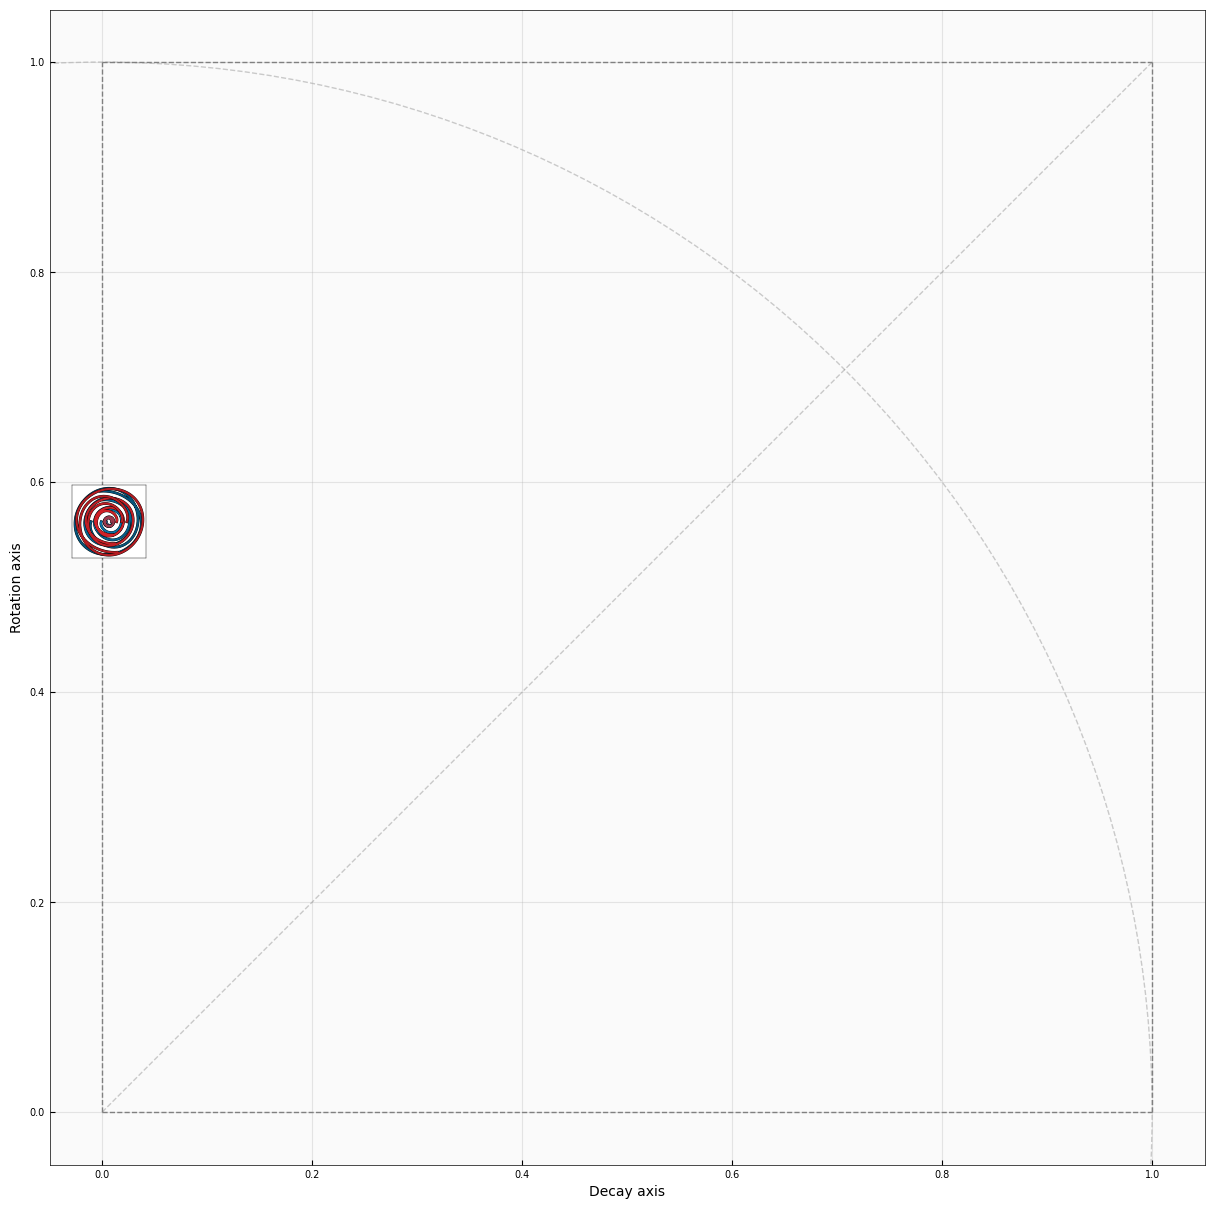

In [7]:
plot_dataset_gyration_plane(cond_n=8, h5_save_dir=dirname)